In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

In [5]:
df_csc_all = pd.read_csv('data/allcsc.csv') # All CSC

In [46]:
# Rafael's case (with parallax)
df_good1 = pd.read_csv('data/likely_matches_plane.csv')

df_good = df_good1.query("prob >= 0.95 and separation <= 0.2 and parallax == parallax and parallax >= 0")
df_good['csc2_name'] = df_good.csc2_pref + ' ' +  df_good.csc2_id
df_good = df_good.merge(df_csc_all, left_on='csc2_name', right_on='name', how='left')

df_bad = pd.read_csv('data/unlikely_matches_plane.csv')
df_bad['csc2_name'] = df_bad.csc2_pref + ' ' +  df_bad.csc2_id
df_bad = df_bad.merge(df_csc_all, left_on='csc2_name', right_on='name', how='left')
 
df_good['gmag_logflux'] = df_good['phot_g_mean_mag'] + np.log10( 1 + df_good['flux_aper_b'])
df_bad['gmag_logflux'] = df_bad['phot_g_mean_mag'] + np.log10( 1 + df_bad['flux_aper_b'])

df_all = pd.concat([df_good, df_bad], ignore_index=True)




/tmp/ipykernel_222841/2757437712.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good['csc2_name'] = df_good.csc2_pref + ' ' +  df_good.csc2_id


In [63]:
np.log10(df_good['flux_aper_b'])

/home/ubunsam/miniconda3/envs/starsml/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0      -14.082383
1      -15.043072
2      -14.761692
3      -14.317215
4      -14.998683
          ...    
5759   -14.704213
5760   -14.625015
5761   -14.661743
5762   -14.454981
5763   -13.486211
Name: flux_aper_b, Length: 5764, dtype: float64

In [64]:
df_good['flux_aper_b'].median()

3.38493522110365e-15

In [47]:
# Find the intersection of 'csc2_id' in both df_good and df_bad
intersecting_ids = set(df_good['csc2_id']).intersection(set(df_bad['csc2_id']))

# Filter the dataframes to only include these intersecting IDs
df_good_intersect = df_good[df_good['csc2_id'].isin(intersecting_ids)]
df_bad_intersect = df_bad[df_bad['csc2_id'].isin(intersecting_ids)]

# This will filter df_bad_intersect to only include rows where the source_id is NOT in df_good_intersect
df_bad_not_in_good = df_bad_intersect[~df_bad_intersect.source_id.isin(df_good_intersect.source_id)]



In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='mollweide')
ax.set_rasterization_zorder(1)

skycoord = SkyCoord(ra=df_good_intersect['csc2_ra']*u.degree, dec=df_good_intersect['csc2_dec']*u.degree, frame='icrs')
galactic = skycoord.galactic
l_rad = galactic.l.wrap_at(180*u.degree).radian
b_rad = galactic.b.radian

df_good_intersect['l_rad'] = l_rad
df_good_intersect['b_rad'] = b_rad

# KDE plot for good samples
sns.scatterplot(data= df_good_intersect, x='l_rad', y='b_rad', ax=ax, rasterized=True)

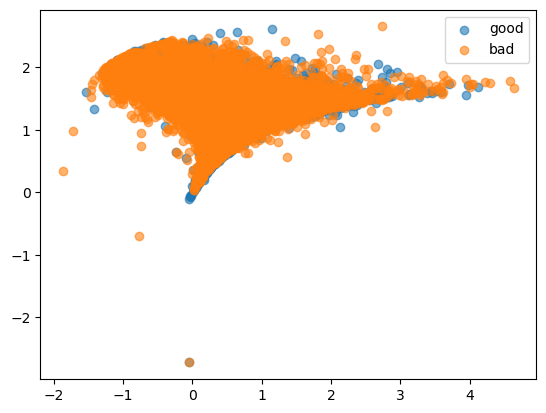

In [43]:
plt.scatter(df_good['bp_g'],df_good['g_rp'],alpha=0.6, label='good')
plt.scatter(df_bad['bp_g'],df_bad['g_rp'],alpha=0.6, label='bad')
plt.legend()

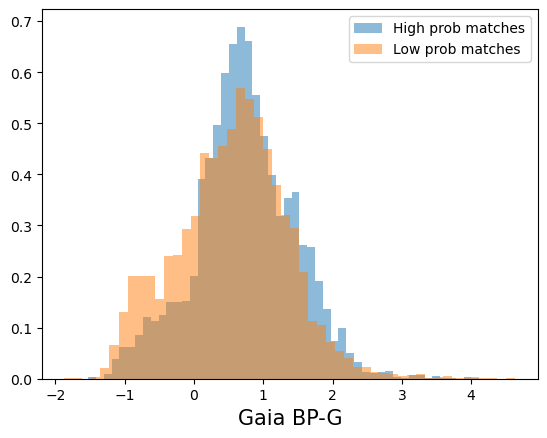

In [33]:
plt.hist(df_good['bp_g'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['bp_g'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-G',size=15)
plt.legend()
#plt.savefig('figures/Gaia_BP_G.pdf',dpi=300)

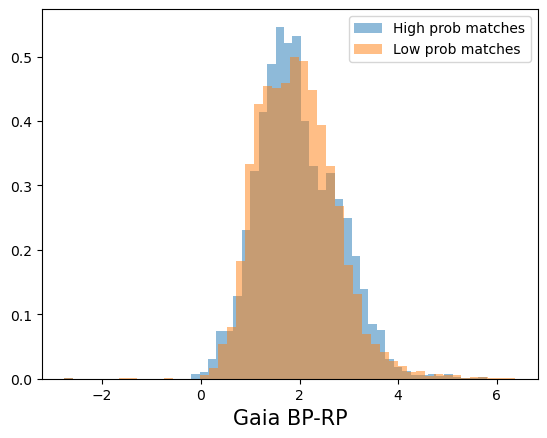

In [34]:
plt.hist(df_good['bp_rp'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['bp_rp'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-RP',size=15)
plt.legend()
#plt.savefig('figures/Gaia_BP_RP.pdf',dpi=300)

/home/ubunsam/miniconda3/envs/starsml/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


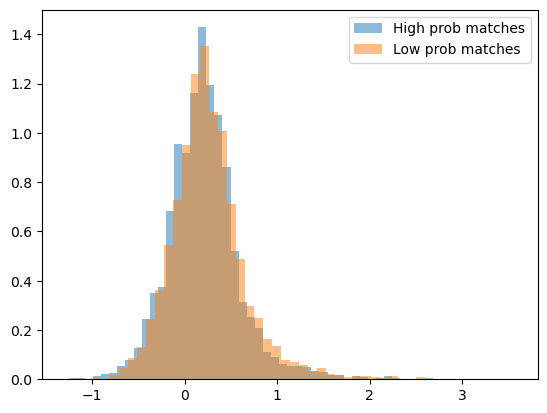

In [35]:
plt.hist(np.log10(1/df_good['parallax']),bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(np.log10(1/df_bad['parallax']),bins=50,alpha=0.5,density=True,label='Low prob matches')
#plt.xlabel('Gaia G-RP',size=15)
plt.legend()
#plt.savefig('figures/Gaia_G_RP.pdf',dpi=300)

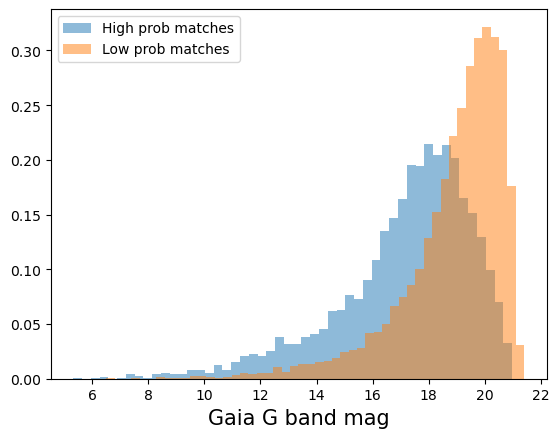

In [36]:
plt.hist(df_good['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia G band mag',size=15)
#plt.xscale('log')
plt.legend()
#plt.savefig('figures/Gaia_G_mag.pdf',dpi=300)

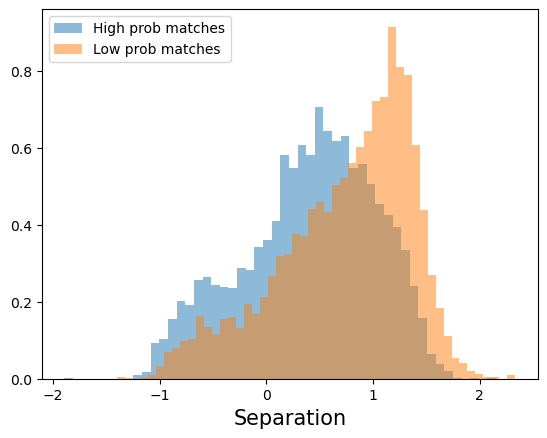

In [37]:
plt.hist(np.log10(100./df_good['phot_bp_mean_flux_over_error']),bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(np.log10(100./df_bad['phot_bp_mean_flux_over_error']),bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Separation',size=15)
#plt.xscale('log')
plt.legend()
#plt.savefig('figures/Gaia_G_mag.pdf',dpi=300)

---
#### Preprocessing

In [44]:
feature_names = [ 
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_over_error',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b',
    'flux_aper_b',
    'gmag_logflux'
]

# List of features to skip for the log transformation
skip_log_features = [ 
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b',
    'gmag_logflux'
]

from utils import preprocess, transform_features, handle_missing_values, standardize

In [52]:
# Preprocess the data
X, Y = preprocess(df_good_intersect, df_bad_not_in_good, feature_names, skip_log_features)
indices = np.arange(X.shape[0])

# Split into training and test sets
(X_train, 
 X_test, 
 Y_train, 
 Y_test, 
 indices_train, 
 indices_test) = train_test_split(X, Y, indices, test_size=0.3, shuffle=True)

# Handle missing values
X_train, X_test, imp_mean = handle_missing_values(X_train, X_test)

# Standardize
#X_train, X_test, scaler = standardize(X_train, X_test)

/mnt/d/workspace/starsml/utils.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(1 + df[feature].values) if feature not in skip_log_features else df[feature].values


In [53]:
from collections import Counter

def class_proportions(y):
    counts = Counter(y)
    total = len(y)
    proportions = {key: value / total for key, value in counts.items()}
    return proportions

train_proportions = class_proportions(Y_train)
test_proportions = class_proportions(Y_test)

print("Training proportions:", train_proportions)
print("Test proportions:", test_proportions)

Training proportions: {1.0: 0.515821970671469, 0.0: 0.484178029328531}
Test proportions: {0.0: 0.47330533893221355, 1.0: 0.5266946610677864}


In [62]:
num_samples = X.shape[0]
nan_count_per_feature = np.isnan(X).sum(axis=0)

# Calculate the percentage for each feature
nan_percentage_per_feature = (nan_count_per_feature / num_samples) * 100

for i, percentage in enumerate(nan_percentage_per_feature):
    print(f"Percentage of NaN values in feature {feature_names[i]}: {percentage:.2f}%")


Percentage of NaN values in feature phot_g_mean_flux: 0.00%
Percentage of NaN values in feature phot_g_mean_flux_error: 0.00%
Percentage of NaN values in feature phot_g_mean_flux_over_error: 0.00%
Percentage of NaN values in feature phot_bp_mean_flux: 29.01%
Percentage of NaN values in feature phot_bp_mean_flux_error: 29.01%
Percentage of NaN values in feature phot_bp_mean_flux_over_error: 29.01%
Percentage of NaN values in feature phot_rp_mean_flux: 29.07%
Percentage of NaN values in feature phot_rp_mean_flux_error: 29.07%
Percentage of NaN values in feature phot_rp_mean_flux_over_error: 29.07%
Percentage of NaN values in feature bp_rp: 29.10%
Percentage of NaN values in feature bp_g: 29.01%
Percentage of NaN values in feature g_rp: 29.07%
Percentage of NaN values in feature parallax: 20.67%
Percentage of NaN values in feature parallax_over_error: 20.67%


---
#### Baseline Models

In [ ]:
# Model Building
clf = LogisticRegression(max_iter=10000)  # max_iter may need to be increased depending on data convergence
clf.fit(X_train, Y_train)

# Predictions
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Precision:", precision_score(Y_test, y_pred))
print("Recall:", recall_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_prob))

#feature_importances = clf.coef_[0]
#for i, imp in enumerate(feature_importances):
#    print(f"{feature_names[i]}: Coefficient = {imp:.4f}")

In [57]:
# Model Building
clf_rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)
clf_rf.fit(X_train, Y_train)

# Predictions
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_prob = clf_rf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print(f"RF train accuracy: {clf_rf.score(X_train, Y_train):.3f}")
print("Accuracy:", accuracy_score(Y_test, y_pred_rf))
print("Precision:", precision_score(Y_test, y_pred_rf))
print("Recall:", recall_score(Y_test, y_pred_rf))
print("F1 Score:", f1_score(Y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_rf_prob))

# Check Scalar and Missing Values
# Error Analysis (check distances of matches in errors)

RF train accuracy: 0.850
Accuracy: 0.7804439112177565
Precision: 0.7622950819672131
Recall: 0.8473804100227791
F1 Score: 0.8025889967637541
AUC-ROC: 0.8568341460457141


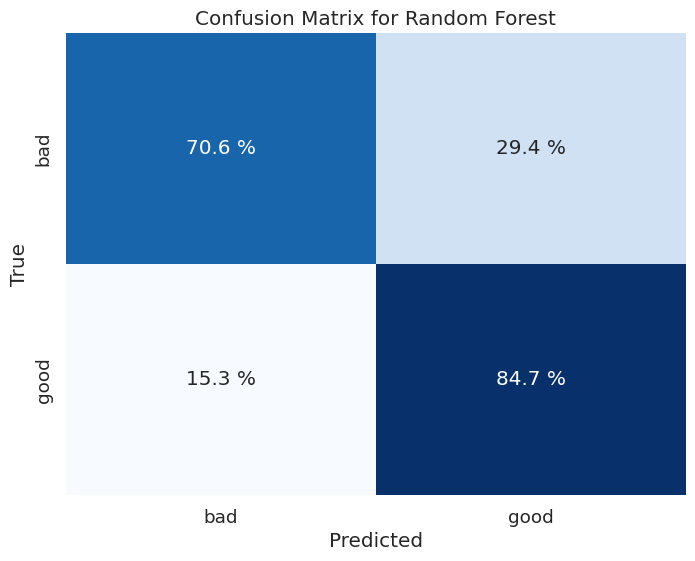

In [58]:
# Compute the confusion matrix and normalize it to get percentages
cm = confusion_matrix(Y_test, y_pred_rf, normalize='true')

# Multiply by 100 to get percentages and round to 1 decimal place
cm_percentage = (cm * 100).round(1)

# Define the class labels
class_labels = ['bad', 'good']

# Create a Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) # Adjust to your preference
sns.heatmap(cm_percentage, annot=True, fmt='', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={'va':'center'},
            )

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest')

# Iterate through the heatmap to add the '%' sign to the annotations
for t in plt.gca().texts:
    t.set_text(t.get_text() + " %")

#plt.savefig('figures/confusion_rf_.png', dpi=300)

/tmp/ipykernel_155577/1477544901.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction'] = y_pred_rf
/tmp/ipykernel_155577/1477544901.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['actual'] = Y_test
/tmp/ipykernel_155577/1477544901.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

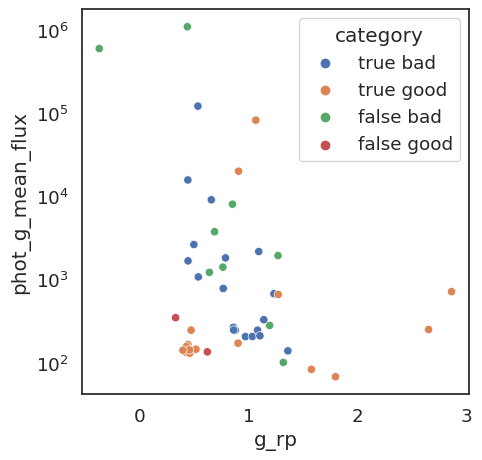

In [60]:
# Concatenate good and bad datasets to refer back later
df_test = df_all.iloc[indices_test]

# Add predictions and actual labels
df_test['prediction'] = y_pred_rf
df_test['actual'] = Y_test

#df_test = df_test.query('separation <=0.2 and parallax >=0')
# Define categories based on predictions and actual labels
df_test['category'] = df_test.apply(lambda row: 'true good' if row['prediction'] == row['actual'] == 1 else 
                                                  'true bad' if row['prediction'] == row['actual'] == 0 else 
                                                  'false good' if row['prediction'] == 1 else 'false bad', axis=1)

# df_test['category'] = df_test.apply(lambda row: 'true good' if row['prediction'] == row['actual'] == 1 else 
#                                                   'false bad' if row['prediction'] == 0 and row['actual'] == 1 else None, axis=1)

# df_test['category'] = df_test.apply(lambda row: 'true bad' if row['prediction'] == row['actual'] == 0 else 
#                                                   'false good' if row['prediction'] == 1 and row['actual'] == 0 else None, axis=1)

# Plot
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")


sns.scatterplot(data = df_test, x='g_rp', y='phot_g_mean_flux', 
            hue='category')
plt.yscale('log')

plt.show()


In [60]:
# Sample dataframes (replace these with your real df_train, df_test, df_totest)
df_train = df_all.iloc[indices_train]
df_train['prediction'] = clf_rf.predict(X_train)
df_train['actual'] = Y_train
y_train_rf_prob = clf_rf.predict_proba(X_train)[:, 1]

df_test = df_all.iloc[indices_test]
df_test['prediction'] = y_pred_rf
df_test['actual'] = Y_test

# List of dataframes and their names
dfs = [df_train, df_test]
names = ['Train', 'Test']

features = feature_names

/tmp/ipykernel_222841/3311305092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['prediction'] = clf_rf.predict(X_train)
/tmp/ipykernel_222841/3311305092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['actual'] = Y_train
/tmp/ipykernel_222841/3311305092.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [61]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('figures/distributions_predicted_datasets_rafas.pdf') as pdf:
    for feature in features:
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 3 columns for Train, Test, ToTest
    
        for ax, df, name in zip(axs, dfs, names):
            ax.hist(df[df['prediction'] == 1][feature], bins=20, alpha=0.5, label='Good')
            ax.hist(df[df['prediction'] == 0][feature], bins=20, alpha=0.5, label='Bad')
            ax.set_title(f'{name} - {feature}')
            ax.legend()

        pdf.savefig(fig);  # Saves the current figure into a pdf page
        plt.close();  # Close the figure to free up memory

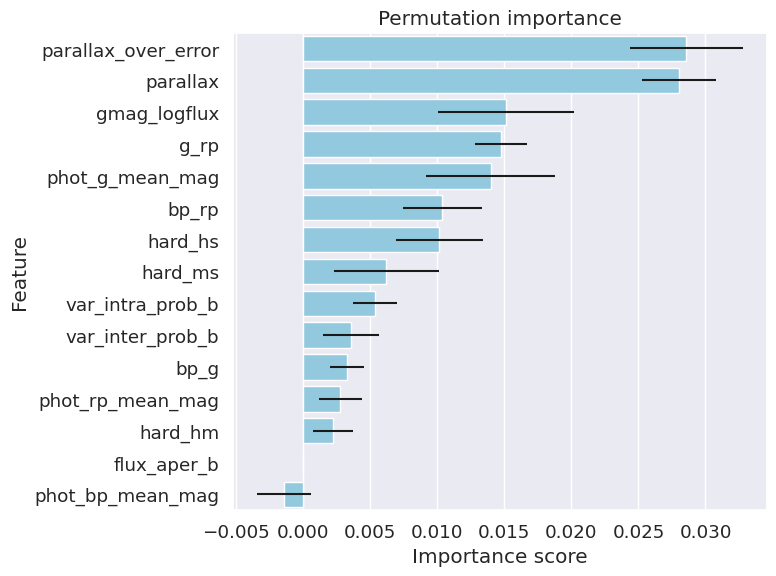

In [59]:
# Calculate permutation importances
per_importances = permutation_importance(
    clf_rf, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2
)

# Sort the features by importance in descending order
sorted_idx = per_importances.importances_mean.argsort()[::-1]

# Create a Pandas DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': np.array(feature_names)[sorted_idx],
    'Importance': per_importances.importances_mean[sorted_idx],
    'Importance_std': per_importances.importances_std[sorted_idx]
})

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue', errorbar=None, capsize=.1, xerr=importance_df['Importance_std'])

# Add labels and title
plt.title("Permutation importance")
plt.xlabel("Importance score")
plt.tight_layout()

In [ ]:
# Model Building
clf_svm = SVC(kernel='linear', probability=True, random_state=42)  # Using 'linear' kernel as a baseline. Probability is True for AUC-ROC.
clf_svm.fit(X_train, Y_train)

# Predictions
y_pred_svm = clf_svm.predict(X_test)
y_pred_svm_prob = clf_svm.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred_svm))
print("Precision:", precision_score(Y_test, y_pred_svm))
print("Recall:", recall_score(Y_test, y_pred_svm))
print("F1 Score:", f1_score(Y_test, y_pred_svm))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_svm_prob))

#### NN

In [19]:
network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=(15,)))
network.add(layers.Dense(64, activation='relu', input_shape=(128,)))
network.add(layers.Dense(1, activation='sigmoid'))

In [20]:
Adagrad = optimizers.Adagrad(learning_rate=0.005)
network.compile(optimizer=Adagrad,
                loss='binary_crossentropy',
                metrics=['binary_accuracy'])
#optimizer.lr.set_value(0.02)

In [22]:
history = network.fit(X_train, Y_train, validation_split=0.2, epochs=200, batch_size=256, verbose=False)

In [23]:
network.save('models/model2_2082023.h5')

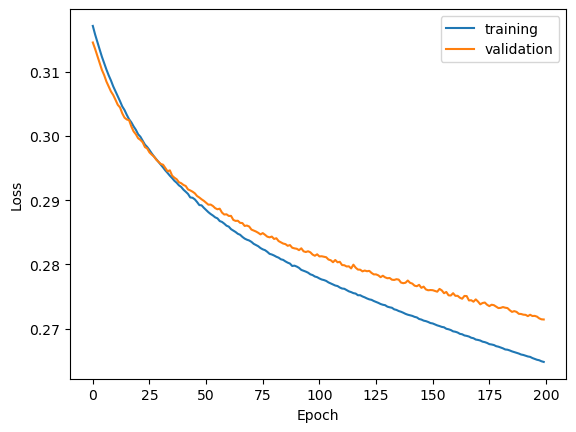

In [24]:
# 200, don't stop until overtfit. 
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('models/loss_nn2_random.pdf')

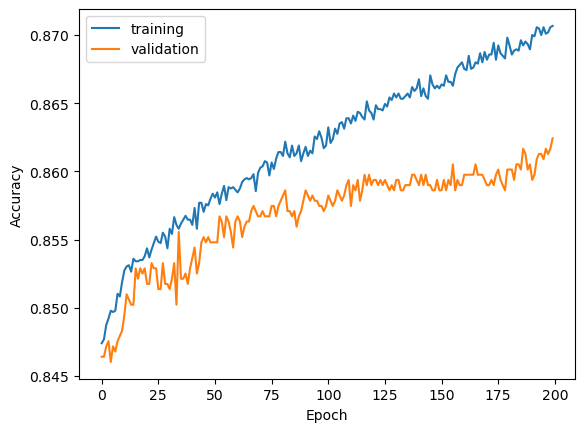

In [25]:
plt.plot(history.history['binary_accuracy'],label='training')
plt.plot(history.history['val_binary_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('figures/acc_nn2_random.pdf')

In [26]:
print('\n# Evaluate on test data')
results = network.evaluate(X_test, Y_test, batch_size=256)
print('test loss, test acc:', results)


# Evaluate on test data
22/22 [==============================] - 0s 8ms/step - loss: 0.2668 - binary_accuracy: 0.8645
test loss, test acc: [0.26681530475616455, 0.8644610643386841]


In [27]:
# Predict probabilities for the test set
y_pred_probs = network.predict(X_test).ravel()

# Convert probabilities to class labels (0 or 1) using a threshold, typically 0.5 for binary classification
y_pred_label = (y_pred_probs > 0.5).astype(int)

# Compute precision, recall, and F1 score
precision = precision_score(Y_test, y_pred_label)
recall = recall_score(Y_test, y_pred_label)
f1 = f1_score(Y_test, y_pred_label)

# Compute ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Display metrics
print('\n# Extended Evaluation Metrics')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC:', roc_auc)


176/176 [==============================] - 1s 5ms/step

# Extended Evaluation Metrics
Precision: 0.7455310199789695
Recall: 0.8360849056603774
F1 Score: 0.7882156753752084
AUC: 0.9414277638673959


In [32]:
# Compute permutation importance
importances = compute_permutation_importance(clf_rf, X_test, Y_test)

# Display the importances
for i, imp in enumerate(importances):
    print(f"{feature_names[i]}: Importance = {imp:.4f}")

phot_g_mean_flux: Importance = 0.0000
phot_g_mean_flux_error: Importance = 0.1347
phot_g_mean_flux_over_error: Importance = 0.0053
phot_bp_mean_flux: Importance = 0.0000
phot_bp_mean_flux_error: Importance = 0.0053
phot_bp_mean_flux_over_error: Importance = 0.0044
phot_rp_mean_flux: Importance = -0.0004
phot_rp_mean_flux_error: Importance = 0.0291
phot_rp_mean_flux_over_error: Importance = 0.0035
bp_rp: Importance = 0.0004
bp_g: Importance = 0.0009
g_rp: Importance = 0.0031
parallax: Importance = 0.0013
parallax_over_error: Importance = 0.0009


In [ ]:
nn_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Create a DataFrame to allow Seaborn plotting
importance_df = pd.DataFrame({'Feature': nn_importances.index, 'Importance': nn_importances.values})

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue')
plt.title("Feature importances using permutation importance (NN)")
plt.xlabel("Importance score")
plt.tight_layout()
#plt.savefig('figures/importances_nn_random.pdf', dpi=300)